# Dust
---

In [1]:
import os
import sys

curdir = os.getcwd()
datdir = f'{curdir}/../data/'
moddir = f'{curdir}/../models/'
resdir = f'{curdir}/../results/'

import numpy             as np
import matplotlib.pyplot as plt
import magritte.tools    as tools
import magritte.setup    as setup
import magritte.core     as magritte

dimension = 1
npoints   = 50
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 1

nH2  = 1.0E+12                 # [m^-3]
nTT  = 1.0E+03                 # [m^-3]
temp = 4.5E+00                 # [K]
turb = 0.0E+00                 # [m/s]
dx   = 1.0E+12                 # [m]
dv   = 0.0E+00 / magritte.CC   # [fraction of speed of light]

In [2]:
modelName = f'all_constant_single_ray'
modelFile = f'{moddir}{modelName}.hdf5'
lamdaFile = f'{datdir}test.txt'


model = magritte.Model ()
model.parameters.set_spherical_symmetry(False)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set([[i*dx, 0, 0] for i in range(npoints)])
model.geometry.points.velocity.set([[i*dv, 0, 0] for i in range(npoints)])

model.chemistry.species.abundance = [[     0.0,    nTT,  nH2,  0.0,      1.0] for _ in range(npoints)]
model.chemistry.species.symbol    =  ['dummy0', 'test', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))
    
model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

##### DUST #####
freqs   = [0.0, model.lines.lineProducingSpecies[0].linedata.frequency[0]]
kappa   = [0.0, 1.0]
density = [0.0 for i in range(npoints)] # [1.0e-17 for i in range(npoints)]
T_dust  = [1.0e+3  for i in range(npoints)]
################

model.dust.freqs  .set(freqs)
model.dust.kappa  .set(kappa)
model.dust.density.set(density)

model.thermodynamics.temperature.dust.set(T_dust)
    
model.write()

Text(0, 0.5, 'Mean intensity [W/m$^{2}$]')

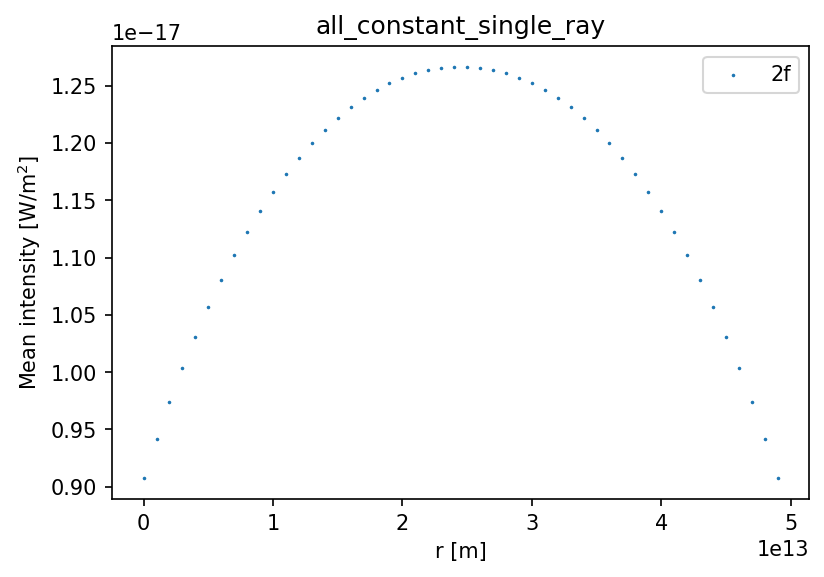

In [3]:
model = magritte.Model (modelFile)

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

model.compute_radiation_field_feautrier_order_2 ()

u_2f = np.array(model.radiation.u)

x  = np.array(model.geometry.points.position)[:,0]
nu = np.array(model.radiation.frequencies.nu)

ld = model.lines.lineProducingSpecies[0].linedata

k = 0

frq = ld.frequency[k]
pop = tools.LTEpop         (ld, temp) * nTT
phi = tools.profile        (ld, k, temp, (turb/magritte.CC)**2, frq)
eta = tools.lineEmissivity (ld, pop)[k] * phi
chi = tools.lineOpacity    (ld, pop)[k] * phi
src = tools.lineSource     (ld, pop)[k]
bdy = tools.I_CMB          (frq)

def I_0 (x):
    return src + (bdy-src)*np.exp(-chi*x)

def I_1 (x):
    return src + (bdy-src)*np.exp(-chi*(x[-1]-x))

def u_ (x):
    return 0.5 * (I_0(x) + I_1(x))

error_u_2f = tools.relative_error (u_(x), u_2f[0,:,0])

fig = plt.figure(dpi=150)
plt.title(modelName)
plt.scatter(x, u_2f[0,:,0], s=0.5, label='2f', zorder=1)
# plt.plot(x, u_(x), c='lightgray', zorder=0)
plt.legend()
# plt.xscale('log')
plt.xlabel('r [m]')
plt.ylabel('Mean intensity [W/m$^{2}$]')

In [4]:
u_2f

array([[[9.07182253e-18],
        [9.41653334e-18],
        [9.73684858e-18],
        [1.00342278e-17],
        [1.03100259e-17],
        [1.05654998e-17],
        [1.08018133e-17],
        [1.10200434e-17],
        [1.12211843e-17],
        [1.14061526e-17],
        [1.15757911e-17],
        [1.17308727e-17],
        [1.18721041e-17],
        [1.20001289e-17],
        [1.21155302e-17],
        [1.22188341e-17],
        [1.23105111e-17],
        [1.23909791e-17],
        [1.24606047e-17],
        [1.25197050e-17],
        [1.25685495e-17],
        [1.26073607e-17],
        [1.26363153e-17],
        [1.26555455e-17],
        [1.26651387e-17],
        [1.26651387e-17],
        [1.26555455e-17],
        [1.26363153e-17],
        [1.26073607e-17],
        [1.25685495e-17],
        [1.25197050e-17],
        [1.24606047e-17],
        [1.23909791e-17],
        [1.23105111e-17],
        [1.22188341e-17],
        [1.21155302e-17],
        [1.20001289e-17],
        [1.18721041e-17],
        [1.1